# 제주핫플레이스 지도 만들기

## 1. 데이터 가져오기

In [57]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving 제주핫플레이스.csv to 제주핫플레이스 (1).csv


In [58]:
import pandas as pd
raw_df = pd.read_csv(filename)
raw_df.head()

,content,date,like,place,tags
0,더 늦기전에 제주도로 떠나쟈😍.#제주핫플레이스 간단히 1탄 모아봄!#제주여행 요 필...,2018-12-07,"1,402",NaN,"['#제주핫플레이스', '#제주여행', '#제주여행', '#제주도여행', '#제주가..."
1,12월에 제주도를 가야하는이유🍊.#제주핫플 모음 끝판왕😍이거 하나면 겨울 #제주여행...,2018-12-03,368,NaN,"['#제주핫플', '#제주여행', '#제주', '#제주도', '#제주도맛집', '#..."
2,11월 놓치지 말아야 할 제주 관광.가을바람이 최고조에 이르는 11월추운 겨울을 앞...,2018-11-02,166,NaN,"['#honestin', '#어니스틴', '#제주여행', '#제주', '#제주도',..."
3,국민학교세대#제주관광#제주살이#제주이주민#아라동주민#삼남매집 #새해첫날#드라이브#명...,2019-01-01,28,명월국민학교,"['#제주관광', '#제주살이', '#제주이주민', '#아라동주민', '#삼남매집'..."
4,#제주관광 #제주 #돔나이트 #스트레스 #풀자 #춤추며 #땀날려 #가끔은괜찮아 #인...,2019-01-01,12,NaN,"['#제주관광', '#제주', '#돔나이트', '#스트레스', '#풀자', '#춤추..."


In [59]:
location_counts = raw_df.place.value_counts().to_frame()
print(location_counts.shape)
location_counts.head()


(1027, 1)


,place
Jeju,241
Jeju-do,172
Jungle Book by Alice,101
Seogwipo,65
제주도 크리스마스 박물관,59


In [60]:
location_counts.tail()

,place
충남 대천 해수욕장 에서,1
뽕끄랑,1
바보까페,1
우리집아점,1
무수천계곡,1


In [61]:
location_counts.to_csv('location_counts.csv')

In [62]:
loc_df = pd.read_csv('location_counts.csv')
loc_df.columns = ['지명','빈도']
loc_df.head()

,지명,빈도
0,Jeju,241
1,Jeju-do,172
2,Jungle Book by Alice,101
3,Seogwipo,65
4,제주도 크리스마스 박물관,59


## 2. 카카오 검색 api를 통한 장소 검색

### 카카오 장소검색

In [63]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving kakaoapikey.txt to kakaoapikey (1).txt


In [64]:
with open(filename) as f:
    api_key = f.read()

In [65]:
import requests
from urllib.parse import quote

In [66]:
keyword = '정방폭포'
search_url = 'https://dapi.kakao.com/v2/local/search/keyword.json'
url = f'{search_url}?query={quote(keyword)}'
# Authorization: KakaoAK {REST_API_KEY}
result = requests.get(url,
            headers={"Authorization": f'KakaoAK {api_key}'}).json()
result['documents'][0]

{'address_name': '제주특별자치도 서귀포시 동홍동 299-3',
 'category_group_code': '',
 'category_group_name': '',
 'category_name': '여행 > 관광,명소 > 폭포',
 'distance': '',
 'id': '10717401',
 'phone': '064-733-1530',
 'place_name': '정방폭포',
 'place_url': 'http://place.map.kakao.com/10717401',
 'road_address_name': '',
 'x': '126.571605283591',
 'y': '33.2449966137286'}

In [67]:
result['documents'][0]

{'address_name': '제주특별자치도 서귀포시 동홍동 299-3',
 'category_group_code': '',
 'category_group_name': '',
 'category_name': '여행 > 관광,명소 > 폭포',
 'distance': '',
 'id': '10717401',
 'phone': '064-733-1530',
 'place_name': '정방폭포',
 'place_url': 'http://place.map.kakao.com/10717401',
 'road_address_name': '',
 'x': '126.571605283591',
 'y': '33.2449966137286'}

In [68]:
import numpy as np 
import re

In [69]:
def find_place(keyword):
    url = f'{search_url}?query={quote(keyword)}'
    result = requests.get(url,
                headers={"Authorization": f'KakaoAK {api_key}'}).json()
    try:
        name = result['documents'][0]['place_name']
        if '제주특별자치도' not in result['documents'][0]['address_name']:
            lng = np.nan
            lat = np.nan
        else:
            lng = float(result['documents'][0]['x'])
            lat = float(result['documents'][0]['y'])
    except:
        print(keyword)
        name = ''
        lng = np.nan
        lat = np.nan

    return name, lng, lat, keyword

In [70]:
find_place('구좌지앵')

('구좌지앵', 126.90617413482926, 33.49540702573199, '구좌지앵')

In [71]:
re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]', '', '제주도 서귀포 중문관광단지 濟州島西歸浦中文觀光團地')

'제주도 서귀포 중문관광단지 '

In [52]:
find_place('제주공항')

('제주국제공항', 126.492769004244, 33.5070789578184, '제주공항')

In [72]:
# loc_df에 공식명칭, 위도, 경도 정보 추가
name_list, lng_list, lat_list = [],[],[]
for place in loc_df.지명:
    place = re.sub('[^가-힣0-9 ]', '', place).strip()
    if place:
        name, lng, lat, _ = find_place(place)
    else:
        name, lng, lat = '', np.nan, np.nan
    name_list.append(name)
    lng_list.append(lng)
    lat_list.append(lat)

제주고궁한복카페
위미2리 동백군락지
제주 꿈꾸는고래 스쿠버게스트하우스
까사 린다 펜션
제주 성산 신산포구자연산횟집 회포장
성산일출봉 게스트하우스 파티 띵까게스트하우스
아날로그감귤체험
함덕반하다
해발1950 한라산 백록담
스윗슬로
비브레이브 커피 로스터즈
2월22일 브런치카페
쌀다방
제주 조류공원 화조원
윗세오름해발 1700
빨간모자마법사
제주 서귀포 그릴 데미그라스
제스토리 바이제주 제주감성소품
애월해안가
붉은못허브팜   애월본점
소자38
네이처캔바스
새별오름 정상
해물뚝배기전문 재암식당
미풍해장국  중앙점
제주도가는 비행기 안
빌리엔젤 제주노형점
백리향백반
제주아트리움비밀의그림자공연
비양도 해녀촌
성산수구레국밥
성산일출봉 코앞 쉼터
풍원 한라산볶음밥
유민 아르누보 콜렉션
인공위성 제주
한화아쿠아넷
한라산 정상 해발 1950
김녕 앞바다
단디501
곽지스테이션
머스태쉬커피머스태쉬하우스
제주마라도잠수함
제주도 올레길 6코스 이중섭거리
헤이미쉬제주제주독채펜션
제주신화월드 메리어트 리조트관
몽구네민박
미나마라
평화통일불사리탑사
군산 정상
라비에 와인비스트로
목수금토일
홍대 깐풍기브라더스
기쁨이네 감자탕
섶섬해녀할망카페
핸드테일러 제주점
오샹띠
바굥식당
카페모리베이커스트리트
유채꽃사진촬영소
블루마린하우스
8월의크리스마스 초원사진관
제주도 하늘 위
키아스마
접대  저번에 우리가 만났던 그때
협제 혜변
청초수물회섭국 신관
다만프레르제주신화점
한복입는 선흘집
모던플레이스 리조트
알뜨르프로젝트2018
테라로사이사랑
원더먼트제주
포근한우리집
목포고을 제주도 흑돼지 끝나는 맛
오마주마카롱
제주초가집 곱들락
여수 앞바다
더커피브루
카페 하도섬
의 한모신의 한모
새우조나단
서귀동 2985 세계의 가정식
제주카페 스르륵
릴리펏 제주점 메종글래드호텔
동탄2에 산다
블랙하우스 떡볶이레스토랑
저녁정원
큰엉전망대쉼터
제주 반디앤로제이 펜션  플라워브런치카페
돈테일러익스프레
타시텔레
기원뚝배기
건축카페  섶섬이보이는
카페하도섬엠스테이펜션
몽키비치
하워드존슨 제주 연동 호텔
선화동1061
블루

In [73]:
loc_df['공식명칭'] = name_list
loc_df['위도'] = lat_list
loc_df['경도'] = lng_list
loc_df.head()

,지명,빈도,공식명칭,위도,경도
0,Jeju,241,,NaN,NaN
1,Jeju-do,172,,NaN,NaN
2,Jungle Book by Alice,101,,NaN,NaN
3,Seogwipo,65,,NaN,NaN
4,제주도 크리스마스 박물관,59,바이나흐튼 크리스마스박물관,33.291572,126.327858


In [74]:
# Null 데이터 유무 확인
loc_df.isnull().sum()

지명        0
빈도        0
공식명칭      0
위도      304
경도      304
dtype: int64

In [75]:
# Null 데이터 유무 확인
loc_df.isna().sum()

지명        0
빈도        0
공식명칭      0
위도      304
경도      304
dtype: int64

In [76]:
# Null 데이터 삭제
total_df = loc_df.dropna()        # Null 값이 있는 행을 삭제
total_df.isnull().sum().sum()

0

In [77]:
total_df.head()

,지명,빈도,공식명칭,위도,경도
4,제주도 크리스마스 박물관,59,바이나흐튼 크리스마스박물관,33.291572,126.327858
5,제주에인감귤밭,48,제주에인감귤밭,33.256561,126.539014
7,성산일출봉 城山日出峰 Seongsan Ilchulbong,36,성산일출봉,33.459135,126.940538
8,폼포코식당_pompokokitchen,30,폼포코식당,33.450408,126.919065
9,1100고지,25,한라산1100고지,33.358078,126.462220


## 3. 공식명칭

In [78]:
# 공식명칭 중복 여부
total_df.공식명칭.value_counts()[:10]

올레길 7코스(서귀포-월평 올레)    6
동문재래시장                4
함덕해수욕장                4
세화해변                  3
천지연폭포                 3
협재해수욕장                3
한라산국립공원               3
이호테우해수욕장              3
비자림                   3
제주중문관광단지              3
Name: 공식명칭, dtype: int64

In [79]:
df = total_df.pivot_table(index=['공식명칭','위도','경도'], values='빈도', aggfunc='sum')
df.head()

,,,빈도
공식명칭,위도,경도,
1158족욕카페,33.467075,126.336504,1
702키친,33.498835,126.534134,1
가드망제,33.500991,126.532954,1
가시식당,33.353060,126.771438,2
가시아방국수,33.438605,126.918065,3


In [80]:
df.reset_index(inplace=True)
df.공식명칭.value_counts()[:5]

쇠소깍        1
하도해변       1
과일애        1
시루애월       1
뽈살집 한림점    1
Name: 공식명칭, dtype: int64

In [81]:
df.to_csv('공식명칭.csv', index=False)

## 3. follium 지도 시각화

In [82]:
df.sort_values(by='빈도', ascending=False).head(10)

,공식명칭,위도,경도,빈도
190,바이나흐튼 크리스마스박물관,33.291572,126.327858,59
465,제주에인감귤밭,33.256561,126.539014,48
270,성산일출봉,33.459135,126.940538,38
574,폼포코식당,33.450408,126.919065,30
598,한라산1100고지,33.358078,126.462220,25
407,위미동백나무군락,33.272939,126.674731,24
405,월정리해수욕장,33.556469,126.795805,22
20,고집돌우럭 중문점,33.257981,126.416705,21
383,올레길 7코스(서귀포-월평 올레),33.237386,126.515310,21
614,함덕해수욕장,33.543062,126.669239,20


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)


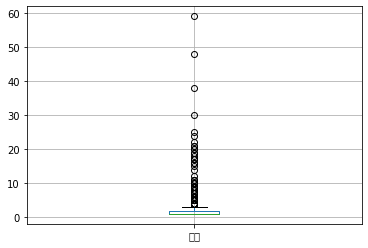

In [83]:
df[['빈도']].boxplot()

In [84]:
import folium

In [85]:
type(df.빈도[0])

numpy.int64

In [86]:
Mt_Hanla = [33.3625, 126.533694]
map = folium.Map(location=Mt_Hanla, zoom_start=11)

for i in df.index:
    folium.CircleMarker(
        radius=int(df.빈도[i]),               # int64는 처리 불가
        location=[df.위도[i], df.경도[i]],    # 위도, 경도
        popup=folium.Popup(df.공식명칭[i], max_width=200),
        tooltip=df.공식명칭[i],
        color='red'
    ).add_to(map)

title = '<h3 align="center" style="font-size:20px">제주도 핫 플레이스</h3>'
map.get_root().html.add_child(folium.Element(title))
map

In [87]:
map.save('제주도 핫플레이스(개별).html')

In [88]:
from folium.plugins import MarkerCluster

locations, names = [], []
for i in df.index:
    locations.append([df.위도[i], df.경도[i]])
    names.append(df.공식명칭[i])

In [89]:

map = folium.Map(location=Mt_Hanla, zoom_start=11)
MarkerCluster(
    locations=locations, popups=names,
    name='제주', overlay=True, control=True
).add_to(map)
title = '<h3 align="center" style="font-size:20px">제주도 핫 플레이스</h3>'
map.get_root().html.add_child(folium.Element(title))
map

In [90]:
map.save('제주도 핫플레이스(그룹).html')